In [1]:
# This is a python script that performs the following procedure.
# On a given input dataset DO:
# Cluster with BIRCH and retrieve and store centroids as 'S'
# Retrieve cluster label for each sample and store as 'cluster_labels'
# Group samples by centroid and save to a matrix.
# Calculate the number of samples per centroid (N) and join to its respective
# centroid on a matrix.
# Cluster the centroids 'S' with DBSCAN.
# Retrieve the cluster labels generated by DBSCAN and match to their respective
# samples according to the centroid the sample is associated with on the original
# dataset.
# The script is influenced by the proposed BIRCHSCAN algorithm from de Moura Ventorim et al.
# However, it does not make use of 'weights' at the DBSCAN step because centroids by definition
# take into account N and LS by way of the following relationship: C = LS/N
# Where N = Number of items in subclusters, and LS =  vector sum of the data points.
# Author: Julio Gamboa
# email: j.a.r.gamboa@gmail.com

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import Birch, DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

In [53]:
# Read input file
df_input = pd.read_csv('H_sapiens_Reduced_Scaled.tsv', sep='\t')

df_input.dropna(inplace=True)
X = df_input.values

In [55]:
# Execute BIRCH algorithm on X
start_time = time()
brc = Birch(threshold=1.2, n_clusters=None)
brc.fit(X)
S = brc.subcluster_centers_
print(f"Time taken to execute BIRCH: {time() - start_time:.4f} seconds")

# Get cluster labels for each sample
cluster_labels = brc.predict(X)

# Group samples by centroid and create a matrix
centroids = np.unique(cluster_labels)
samples_by_centroid = []
for centroid in centroids:
    samples = X[cluster_labels == centroid]
    samples_by_centroid.append(samples)

Time taken to execute BIRCH: 236.1180 seconds


In [56]:
# Create a matrix where samples are associated with each centroid for later identification
data = np.concatenate([np.concatenate([samples, np.full((len(samples), 1), centroid)], axis=1) 
                       for samples, centroid in zip(samples_by_centroid, centroids)], axis=0)

In [57]:
# Save results to TSV file
df = pd.DataFrame(data, columns=[f"dim{i}" for i in range(S.shape[1])] + ['centroid'])
df.to_csv('clustered_samples.tsv', sep='\t', index=False)

In [ ]:
# Retrieve the number of samples per centroid
start_time = time()
Ns = []
for i in range(len(S)):
    subcluster_idx = np.where(brc.predict(X) == i)[0]
    N = len(subcluster_idx)
    Ns.append(N)
print(f"Time taken to get centroids and weights: {time() - start_time:.4f} seconds")

# Save subcluster centers and weights as TSV file. This file becomes the input for DBSCAN
df = pd.DataFrame(S, columns=[f"dim{i}" for i in range(S.shape[1])])
df['weight'] = Ns
df.to_csv('subclusters_and_Ns.tsv', sep='\t', index=False)

In [ ]:
# Plot subclusters
plt.scatter(X[:, 0], X[:, 1], c=brc.predict(X), cmap='viridis', alpha=0.4, edgecolor='k')
plt.scatter(S[:, 0], S[:, 1], c='red', s=10)
plt.title('BIRCH Clustering')
plt.show()

In [40]:
# Cluster the centroids obtained from BIRCH with DBSCAN.
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
t = time()
dbscan_model.fit(S)
print("DBSCAN clustering took %0.2f seconds" % (time() - t))

# Retrieve the labels from DBSCAN clustering
dbscan_labels = dbscan_model.labels_

DBSCAN clustering took 0.00 seconds


In [41]:
df_dbscan = pd.DataFrame({'centroid': centroids, 'dbscan_label': dbscan_labels})
df_dbscan.to_csv('dbscan_results.tsv', sep='\t', index=False)

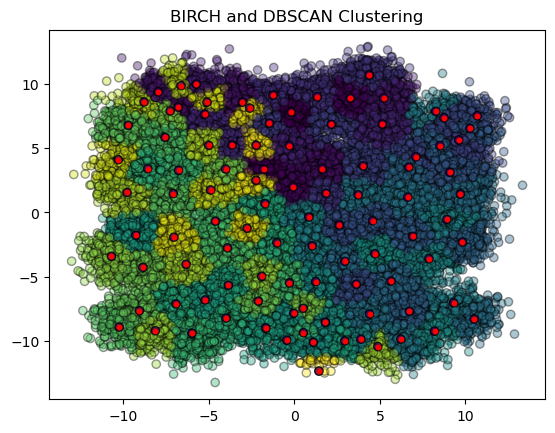

In [44]:
# Plot DBSCAN and BIRCH results
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', alpha=0.4, edgecolor='k')
plt.scatter(df['dim0'], df['dim1'], c=dbscan_labels, cmap='viridis', alpha=0.8, edgecolor='k')
plt.scatter(S[:, 0], S[:, 1], c='red', s=10)
plt.title('BIRCH and DBSCAN Clustering')
plt.show()